# Auswertung 27.05.2025
Auswertung mit vergleich von TBBB TCBC und LNO

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit

import glob
import re

def dat2array(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            line = line.replace(',', '.').replace('\t', ';').replace('\n', '')
            if i >= 39:  # Skip header lines
                data.append(line.split(';'))

    freqs = [float(row[0]) for row in data]
    intensities = [float(row[1]) for row in data]
    return freqs, intensities
    
def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

def gaussian(x, a, mean, sigma):
    return a * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

In [295]:
def create_shg_plot(middle_value, difference, filepath, suptitle, filename_prefix, reference=False):
    x_range = (middle_value - difference, middle_value + difference)
    file_list = glob.glob(filepath)

    sorted_files = []
    for f in file_list:
        meas_no, temperature = extract_info(f)
        if meas_no is not None:
            sorted_files.append((f, meas_no, temperature))

    sorted_files.sort(key=lambda x: x[1])
    
    extended_files = []
    heating = True
    for f, meas_no, temperature in sorted_files:
        if heating and temperature > 435:
            heating = False
        extended_files.append((f, meas_no, temperature, heating))

    temperatures = [x[2] for x in sorted_files]
    norm = plt.Normalize(min(temperatures), max(temperatures))
    colors = cm.plasma(norm(temperatures))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
    peak_list = []
    temps_for_line = []
    peaks_for_line = []

    for idx, (f, meas_no, temperature, heating) in enumerate(extended_files):
        freqs, intensities = dat2array(f)
        # nur wenn reference=True: Reskalierung um Faktor 32.88 für ND2 und 0,07s ausgleichen
        if reference:
            intensities = [val * 32.88 * (10/7) for val in intensities]
        # Normalisierung
        intensities = [val / 131942273.14285715 for val in intensities]
        filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
        filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])

        ax0.plot(filtered_freqs, filtered_intensities, color='lightgray')  # Plot in Hellgrau
        # ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])  # Diese Zeile auskommentieren, um Originalkurve auszublenden
        
        try:
            popt, _ = curve_fit(gaussian, filtered_freqs, filtered_intensities,
                                p0=[max(filtered_intensities), np.mean(filtered_freqs), 10])
            fitted_curve = gaussian(np.array(filtered_freqs), *popt)
            ax0.plot(filtered_freqs, fitted_curve, color=colors[idx])
            area = np.trapezoid(fitted_curve, filtered_freqs)
            # --- Hier erfolgt die x-Achsen-Anpassung ---
            temp_for_plot = temperature  # Standardwert
            if not heating:
                # Temperatur ab 440K wieder kleiner machen
                temp_for_plot = 880 - temperature  # Beispiel: 880-441=439
            ax1.scatter(temperature, area, color='black', marker='o')  # Original auskommentieren
            # ax1.scatter(temp_for_plot, area, color=colors[idx], marker='o')  # Neue Variante
        except RuntimeError:
            ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])
            area = np.trapezoid(filtered_intensities, filtered_freqs)
            ax1.scatter(temperature, area, color='black', marker='x')  # Original auskommentieren
            # ax1.scatter(temp_for_plot, area, color=colors[idx], marker='x')  # Neue Variante

        peak_list.append(area)
        temps_for_line.append(temperature)  # Original auskommentieren
        # temps_for_line.append(temp_for_plot)  # Neue Variante
        peaks_for_line.append(area)

    sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
    cbar.set_label('Temperature in K')
    cbar.set_ticks([min(temperatures), max(temperatures)])
    cbar.set_ticklabels([f"{min(temperatures)} K", f"{max(temperatures)} K"])

    # ax1.plot(temps_for_line, peaks_for_line, color='gray', linewidth=1, alpha=0.7, zorder=0)  # Auskommentiert

    # Finde Index, an dem heating von True auf False wechselt
    heating_flags = [ht for (_, _, _, ht) in extended_files]
    if True in heating_flags and False in heating_flags:
        split_idx = heating_flags.index(False)
        # Rote Linie: bis inkl. letztem heating=True Punkt (also bis split_idx)
        ax1.plot(temps_for_line[:split_idx+1], peaks_for_line[:split_idx+1],
                 color='red', linewidth=1.2, alpha=0.5, zorder=0)
        # Blaue Linie: ab split_idx (also ab dem ersten heating=False Punkt)
        ax1.plot(temps_for_line[split_idx:], peaks_for_line[split_idx:],
                 color='blue', linewidth=1.2, alpha=0.5, zorder=0)
    else:
        # Falls nur heating=True oder nur heating=False existiert
        color = 'red' if all(heating_flags) else 'blue'
        ax1.plot(temps_for_line, peaks_for_line, color=color, linewidth=2, alpha=0.7, zorder=0)

    # set x- and y-axis limits and labels
    ax0.set_xlim(x_range)
    ax0.set_ylim(bottom=0)                   # linke Achse beginnt bei 0
    ax0.set_xlabel('Wavelength in nm')
    
    ax0.set_ylabel('rel. Int. to LiNbO₃-SHG')
    ax1.set_ylabel('Area of Gaussian Fit rel. to LiNbO₃-SHG')

    if reference:
        ax0.set_ylabel('Intensity in arb. u.')
        ax1.set_ylabel('Area of Gaussian Fit in arb. u.')
    
    ax1.set_xlabel('Temperature in K')
    ax1.set_ylim(bottom=0)                   # rechte Achse beginnt bei 0

    fig.suptitle(suptitle, fontsize=16)
    fig.text(0.5, 0.914, "Measurement parameters: Power: 333µW, Slit width=210µm", ha="center")
    plt.show()

    fig.savefig(f'./{filename_prefix}.png', dpi=600, bbox_inches='tight')
    fig.savefig(f'./{filename_prefix}.pdf', dpi=600, bbox_inches='tight')
    # print("The maximum intensity across all temperatures is:", max(peak_list))
    
    # for f, meas_no, temperature, heating in extended_files:
    #     print(f"Datei: {f}, Messnummer: {meas_no}, Temperatur: {temperature} K, Heizen: {heating}")

## TBBB

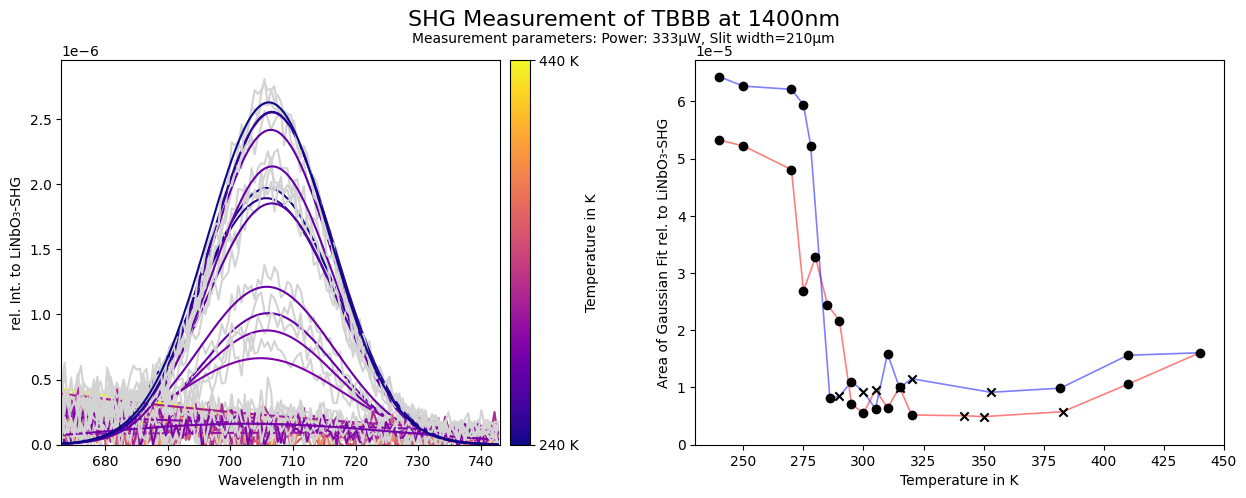

In [296]:
create_shg_plot(
    middle_value=708,
    difference=35,
    filepath='2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Measurement of TBBB at 1400nm',
    filename_prefix='TBBB_SHG'
)

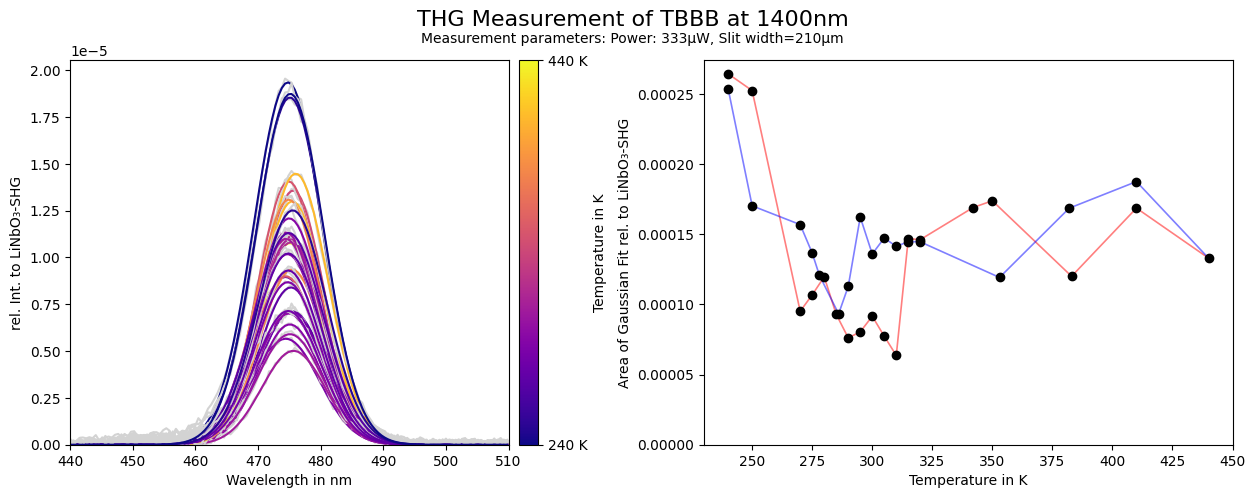

In [297]:
create_shg_plot(
    middle_value=475,
    difference=35,
    filepath='2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of TBBB at 1400nm',
    filename_prefix='TBBB_THG'
)

## TCBC

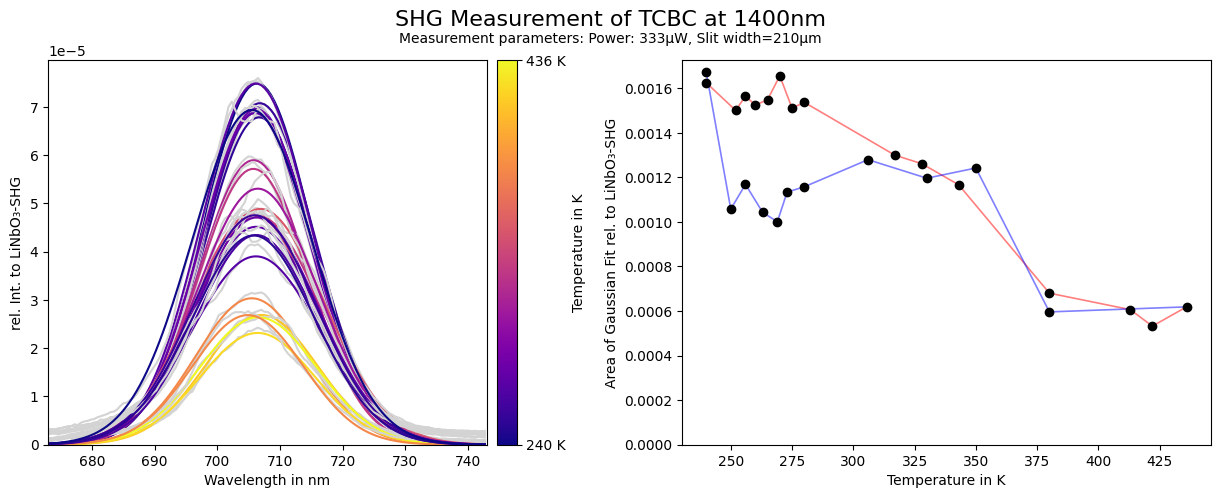

In [298]:
create_shg_plot(
    middle_value=708,
    difference=35,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Measurement of TCBC at 1400nm',
    filename_prefix='TCBC_SHG'
)

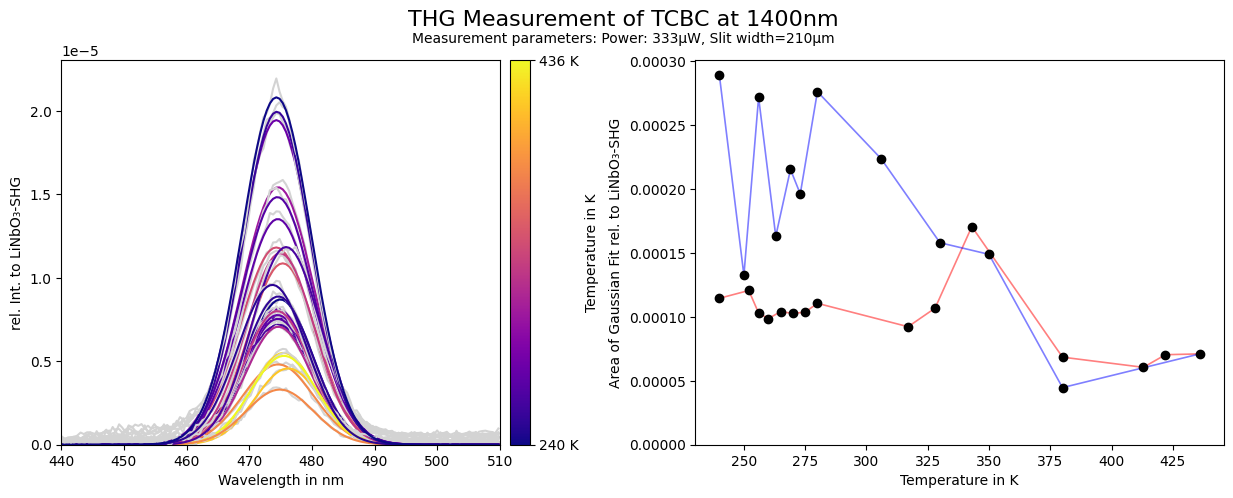

In [299]:
create_shg_plot(
    middle_value=475,
    difference=35,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of TCBC at 1400nm',
    filename_prefix='TCBC_THG'
)

## LNO

#### Vergleichsmessung

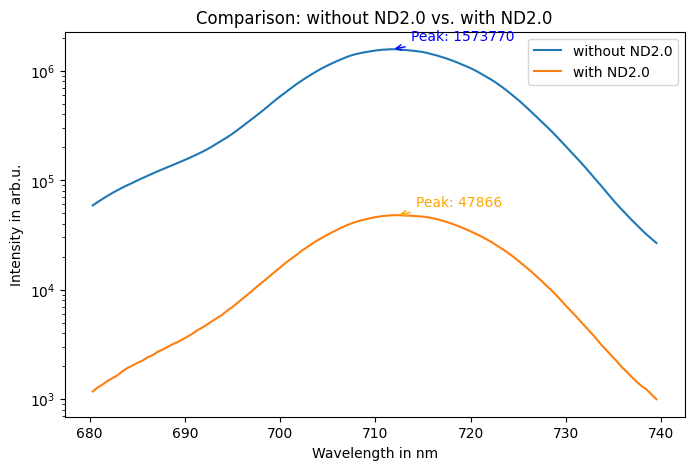

Skalierungsfaktor (ohne ND2.0 / mit ND2.0): 32.88


In [300]:
# Lade die Vergleichsmessungen "mit" und "ohne" ND2.0
files_ohne = glob.glob('2025-05-23 LNO/1400nm/0.333mW_Spalt210um/Vergleichsmessung ND2.0/ohne*.asc')
files_mit = glob.glob('2025-05-23 LNO/1400nm/0.333mW_Spalt210um/Vergleichsmessung ND2.0/mit*.asc')

# Wähle jeweils die erste Datei (ggf. anpassen, falls mehrere vorhanden)
file_ohne = files_ohne[0]
file_mit = files_mit[0]

# Lade die Daten
freqs_ohne, intensities_ohne = dat2array(file_ohne)
freqs_mit, intensities_mit = dat2array(file_mit)

# Filtere den Bereich wie bei x_range
filtered_data_ohne = [(fr, i) for fr, i in zip(freqs_ohne, intensities_ohne) if x_range[0] <= fr <= x_range[1]]
filtered_data_mit = [(fr, i) for fr, i in zip(freqs_mit, intensities_mit) if x_range[0] <= fr <= x_range[1]]

filtered_freqs_ohne, filtered_intensities_ohne = zip(*filtered_data_ohne) if filtered_data_ohne else ([], [])
filtered_freqs_mit, filtered_intensities_mit = zip(*filtered_data_mit) if filtered_data_mit else ([], [])

fig, ax0 = plt.subplots(figsize=(8, 5))
ax0.plot(filtered_freqs_ohne, filtered_intensities_ohne, label='without ND2.0')
ax0.plot(filtered_freqs_mit, filtered_intensities_mit, label='with ND2.0')
ax0.set_title('Comparison: without ND2.0 vs. with ND2.0')
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')
ax0.set_yscale('log')
ax0.legend()

peak_ohne = max(filtered_intensities_ohne)
peak_mit = max(filtered_intensities_mit)
peak_ohne_x = filtered_freqs_ohne[filtered_intensities_ohne.index(peak_ohne)]
peak_mit_x = filtered_freqs_mit[filtered_intensities_mit.index(peak_mit)]

ax0.annotate(f'Peak: {peak_ohne:.0f}', xy=(peak_ohne_x, peak_ohne), xytext=(peak_ohne_x+2, peak_ohne*1.2),
             arrowprops=dict(arrowstyle='->', color='blue'), color='blue', fontsize=10)
ax0.annotate(f'Peak: {peak_mit:.0f}', xy=(peak_mit_x, peak_mit), xytext=(peak_mit_x+2, peak_mit*1.2),
             arrowprops=dict(arrowstyle='->', color='orange'), color='orange', fontsize=10)

plt.show()

# Berechne den Skalierungsfaktor, um die Messung mit ND2.0 auf die ohne ND2.0 zu bringen
skalierungsfaktor = peak_ohne / peak_mit
print(f"Skalierungsfaktor (ohne ND2.0 / mit ND2.0): {skalierungsfaktor:.2f}")

### SHG

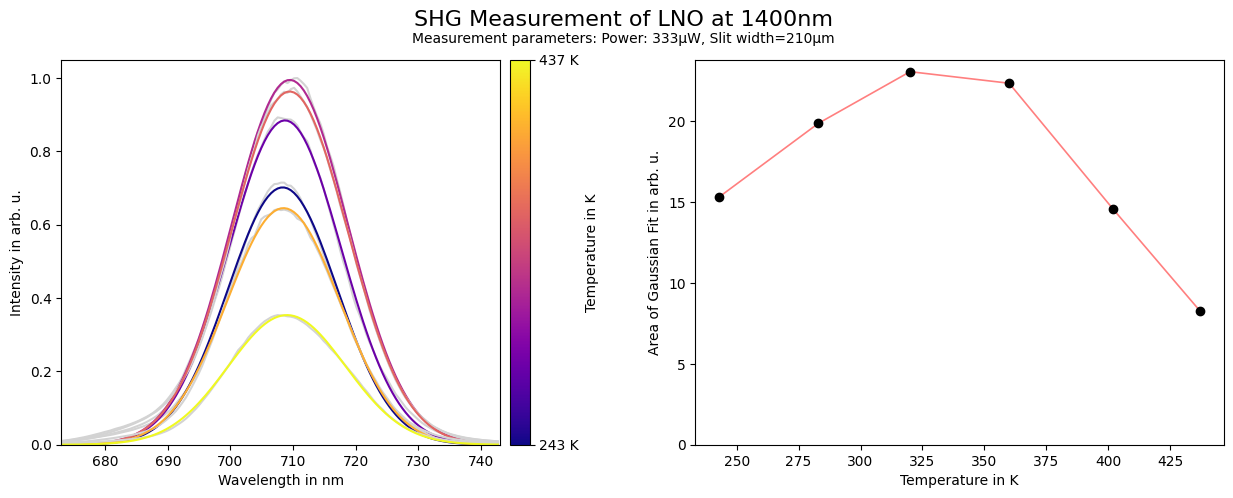

In [301]:
create_shg_plot(
    middle_value=708,
    difference=35,
    filepath='2025-05-23 LNO/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Measurement of LNO at 1400nm',
    filename_prefix='LNO_SHG',
    reference=True
)

### THG

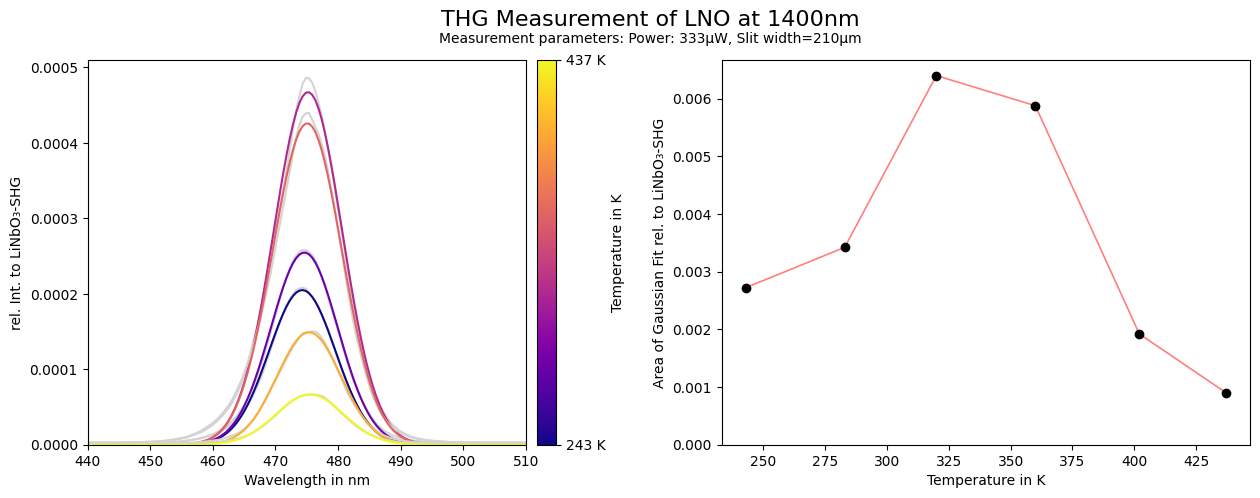

In [302]:
create_shg_plot(
    middle_value=475,
    difference=35,
    filepath='2025-05-23 LNO/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of LNO at 1400nm',
    filename_prefix='LNO_THG'
)